# RNN(Recurrent Neural Network)의 기본 idea<br>
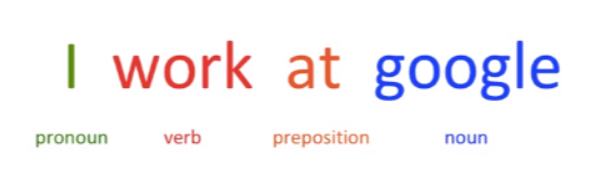<br>
'I'는 주어, 'work'는 동사, 'at'은 전치사, 'google'은 명사라는 건 대부분 알고 있다. 좀 더 구체적으로 들여다보자면 주어인 'I'가 왔기 때문에 그 뒤는 동사일 것이라고 자연스럽게 예측했고, 전치사 'at'이 왔기 때문에 그 뒤는 명사가 올 것이라고 추론할 수 있다. 이러한 일련의 추론 과정을 수학적으로 모델링한 것이 바로 'RNN'이다.

# RNN의 구조
구조는 크게 입력층, 은닉층, 출력층으로 이루어지며, 기본 신경망과의 차이점은 은닉층에서 순환 구조를 가져 순서가 있는 데이터를 처리하는 데 강점을 가진 신경망이라는 점이다.<br>
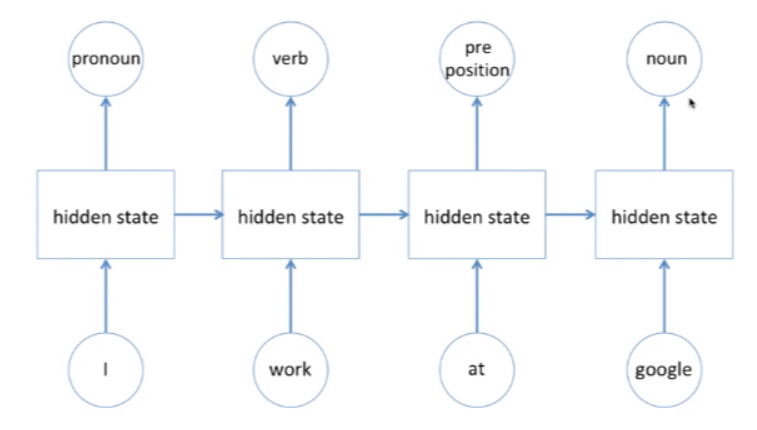<br>
방금 보았던 예시를 4개의 단어를 input으로 받아 품사가 무엇인지 output으로 알려주는 RNN을 다시 표현해본다. input은 동시가 아닌 `순차적`으로 들어오며, 'I'는 `hidden state`라는 것을 거쳐 '주어'라는 것을 미리 알고 있다고 가정한다.<br>
그러면 'I' 다음 'work'를 input으로 받는데, 이 때 hidden state는 'work' 뿐만 아니라 이전 'I'에 대한 데이터를 hidden state를 통해 받아 '동사'라고 판단하게 된다.<br>
마지막으로 'google'이 들어왔을 때는 'google'과 함께 'I', 'work', 'at'에 대한 정보를 함께 조합하여 'google'이 명사일 확률이 높다고 결론을 내린다.<br>

이제 input은 xi, output은 yi, hidden state는 hi로 설정하고 구체적으로 구조를 살펴본다.<br>
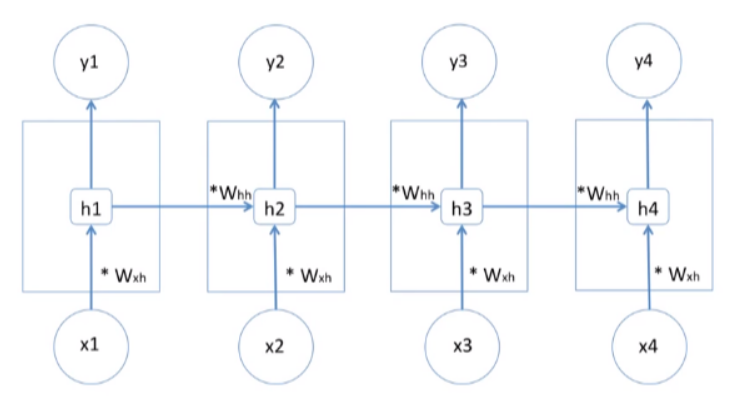<br>
위 그림을 보면 Wxh, Whh가 있는데 이것은 `가중치`이다. 결국 큰 맥락에서 딥러닝의 일종인 RNN은 이전의 input 데이터들을 반영하여 현재의 input 데이터가 무엇인지 판단하는데, 판단의 정확도를 높이기 위해 가중치인 W를 최적화하는 매커니즘을 가지고 있다.

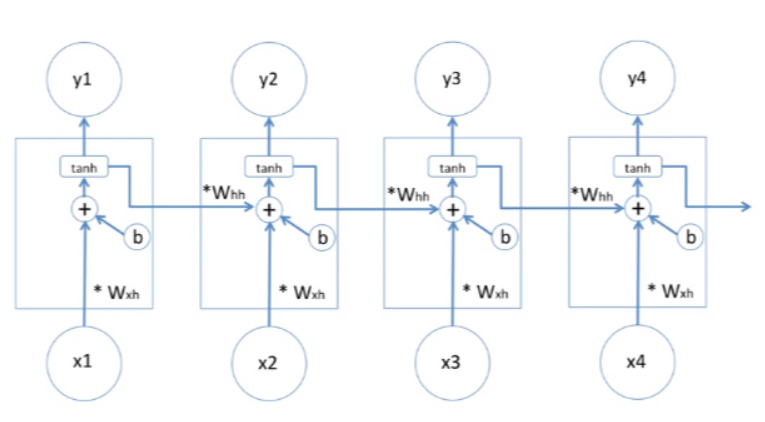<br>
예를 들어 위 그림에서 input으로 x2가 들어왔을 때 hidden state는 x2, 그리고 이전 hidden state를 통해 x1을 받아 output을 출력하게 된다.<br>
이 때 x2는 가중치 Whh가, x1은 가중치 Wxh가 곱해지고 여기에 bias term인 b까지 더해져 만들어진 `Whh * x2 + Wxh * x1 + b`는 `활성함수`인 tanh를 거쳐 최종적인 y2를 도출하게 된다.

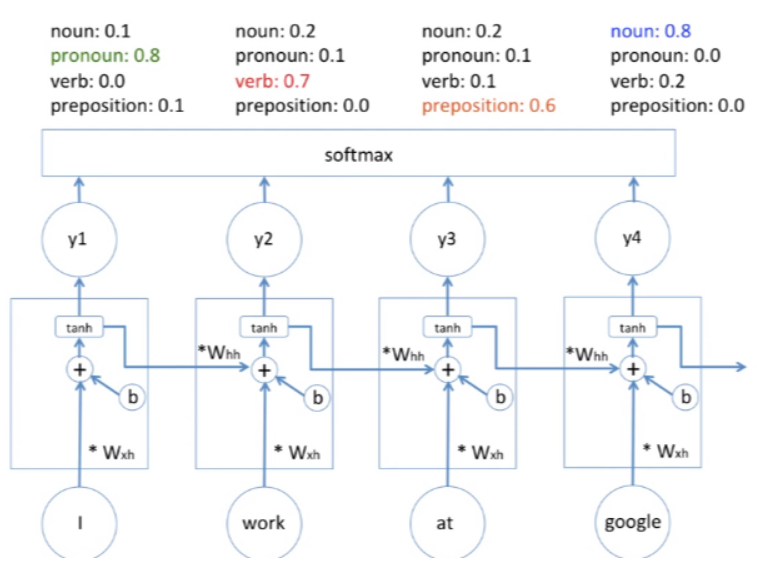<br>
이제 각각 도출한 y값을 활성함수인 softmax에 넣으면 각 단어가 어떤 품사에 해당할지를 확률값으로 알려주고 이 중 제일 확률이 높은 값이 예측값이 된다.<br>

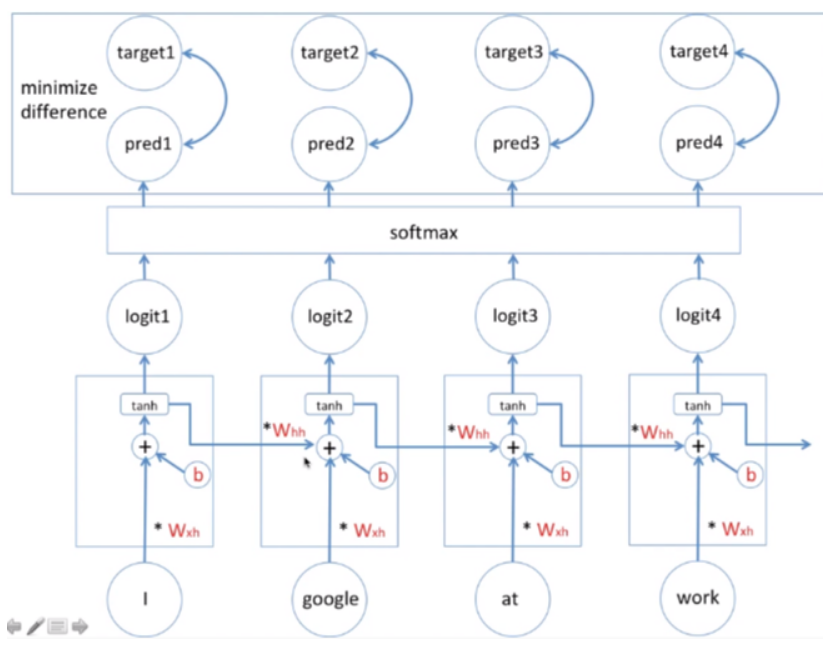<br>
이제 남은 것은 `최적화(Optimization)`이다. 이는 예측값과 실제값의 cost를 줄여나가는 과정을 의미한다. 따라서 Whh, Wxh, b 총 세 가지를 `Gradient Descent Algorithm`을 이용하여 최적화하게 한다.<br>
중요한 점은 위 그림에서 Whh, Wxh, b가 네 개 있는 것처럼 보이지만 실제로는 12개 값이 아닌 3개의 변수라는 점이다.

___

* 모듈 임포트

In [2]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from keras.wrappers.scikit_learn import KerasRegressor

* sqlite DB에서 데이터 불러오기

In [3]:
con = sqlite3.connect(r"C:\Users\gram\OneDrive\바탕 화면\stock_project\stock.db")
df = pd.read_sql("SELECT * FROM '039490'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220516,86900,87600,85700,85900,55383
20220513,84000,87400,83500,85800,86525
20220512,84700,85300,82700,83200,104007
20220511,87500,87500,85500,85800,108071
20220510,87500,88600,87000,88000,100350
...,...,...,...,...,...
20040429,5117,5436,5025,5101,109911
20040428,5071,5452,4995,5444,182604
20040427,5452,5482,5033,5063,299489


* 데이터 정렬

In [4]:
df.sort_index(ascending=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
20040423,6076,6799,5353,5353,1415109
20040426,5436,5741,5261,5398,343283
20040427,5452,5482,5033,5063,299489
20040428,5071,5452,4995,5444,182604
20040429,5117,5436,5025,5101,109911
...,...,...,...,...,...
20220510,87500,88600,87000,88000,100350
20220511,87500,87500,85500,85800,108071
20220512,84700,85300,82700,83200,104007


* 행 인덱스를 datetime 객체로 변환

In [5]:
df.index = pd.DatetimeIndex(df.index)
df.index

DatetimeIndex(['2004-04-23', '2004-04-26', '2004-04-27', '2004-04-28',
               '2004-04-29', '2004-04-30', '2004-05-03', '2004-05-04',
               '2004-05-06', '2004-05-07',
               ...
               '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-06',
               '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12',
               '2022-05-13', '2022-05-16'],
              dtype='datetime64[ns]', name='date', length=4470, freq=None)

* 이동평균값 계산 및 삽입
 * 이동평균값 : 과거 n일동안의 주가를 다 더해서 평균을 낸 것

In [30]:
# 이동평균값 계산하기
ma5 = df['close'].rolling(window=5).mean() # 5일 이동평균선
ma20 = df['close'].rolling(window=20).mean() # 20일 이동평균선
ma60 = df['close'].rolling(window=60).mean() # 60일 이동평균선 

# 거래량 이동평균값 계산하기
vma20 = df['volume'].rolling(window=20).mean()
vma60 = df['volume'].rolling(window=60).mean()
 
# 새로운 데이터 요소 삽입하기
df['MA5'] = ma5
df['MA20'] = ma20
df['MA60'] = ma60
df['VMA20'] = vma20
df['VMA60'] = vma60

df = df.fillna(0) # 결측값 (=> 0으로 치환할 지 drop할 지 최적의 방법에 대해 고민)

df

,open,high,low,close,volume,MA5,MA20,MA60,VMA20,VMA60
date,,,,,,,,,,
2004-04-23,6076,6799,5353,5353,1415109,0.0,0.0,0.000000,0.00,0.000000
2004-04-26,5436,5741,5261,5398,343283,0.0,0.0,0.000000,0.00,0.000000
2004-04-27,5452,5482,5033,5063,299489,0.0,0.0,0.000000,0.00,0.000000
2004-04-28,5071,5452,4995,5444,182604,0.0,0.0,0.000000,0.00,0.000000
2004-04-29,5117,5436,5025,5101,109911,5271.8,0.0,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-05-10,87500,88600,87000,88000,100350,90960.0,95255.0,97528.333333,50372.25,53293.333333
2022-05-11,87500,87500,85500,85800,108071,89460.0,94620.0,97348.333333,53519.75,54291.016667
2022-05-12,84700,85300,82700,83200,104007,87480.0,93785.0,97120.000000,56481.45,55200.783333


* 주가의 중간값 요소 추가

In [31]:
#가격의 중간값 계산하기
high_prices = df['high'].values
low_prices = df['low'].values
mid_prices = (high_prices + low_prices) / 2

#중간 값 요소 추가하기
df['mid'] = mid_prices 

df

,open,high,low,close,volume,MA5,MA20,MA60,VMA20,VMA60,mid
date,,,,,,,,,,,
2004-04-23,6076,6799,5353,5353,1415109,0.0,0.0,0.000000,0.00,0.000000,6076.0
2004-04-26,5436,5741,5261,5398,343283,0.0,0.0,0.000000,0.00,0.000000,5501.0
2004-04-27,5452,5482,5033,5063,299489,0.0,0.0,0.000000,0.00,0.000000,5257.5
2004-04-28,5071,5452,4995,5444,182604,0.0,0.0,0.000000,0.00,0.000000,5223.5
2004-04-29,5117,5436,5025,5101,109911,5271.8,0.0,0.000000,0.00,0.000000,5230.5
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,87500,88600,87000,88000,100350,90960.0,95255.0,97528.333333,50372.25,53293.333333,87800.0
2022-05-11,87500,87500,85500,85800,108071,89460.0,94620.0,97348.333333,53519.75,54291.016667,86500.0
2022-05-12,84700,85300,82700,83200,104007,87480.0,93785.0,97120.000000,56481.45,55200.783333,84000.0


* 주가 시각화

Text(0, 0.5, 'price')

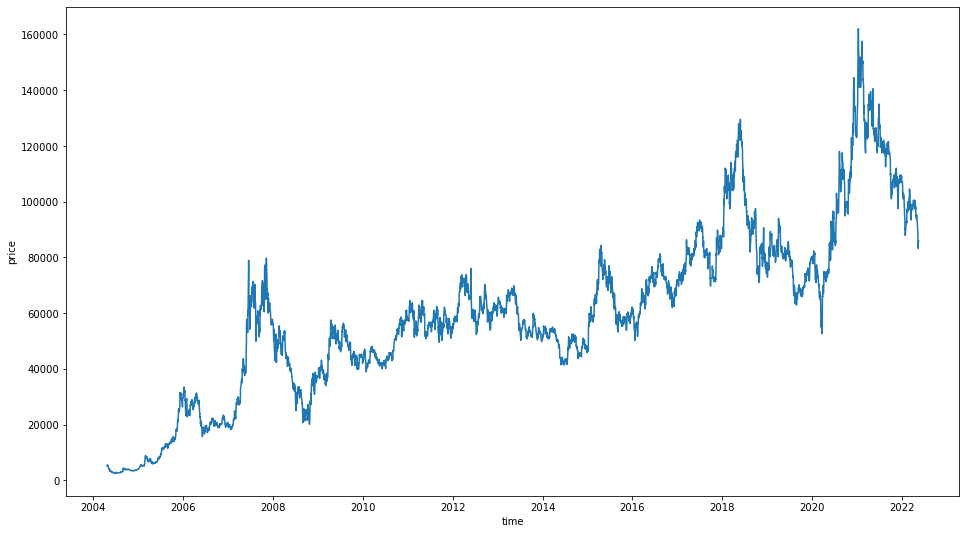

In [32]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

* 골든크로스 : 단기이동평균선이 장기이동평균선을 넘음 (=> 주식이 오르고 있음)
* 데드크로스 : 장기이동평균선이 단기이동평균선을 넘음 (=> 주식이 떨어지고 있음)

In [33]:
gc_point = [] # 골든 크로스 
dc_point =[] # 데드 크로스 

# 모든 값을 0으로 초기화
for i in range(4470): # 4470은 행의 갯수
    gc_point.append(0)
    dc_point.append(0)

In [34]:
index = 0 
for i in range(len(df['MA5'])-1):
    # 5일선과 20일선을 사용하므로 20일 동안은 의미가 없음 
    if index < 20 : 
        pass 
    # 오늘 5일 단기선이 20일 장기선이 보다 작거나 같고, 내일 5일선이 상향돌파 -> 골든 크로스 
    elif df['MA5'][i] <= df['MA20'][i]:
        if df['MA5'][i+1] > df['MA20'][i+1]:
            gc_point[i+1] = 1
        else:
            pass
        
    # 오늘 5일 단기선이 20일 장기선보다 크거나 같고, 내일 5일선이 하향돌파 -> 데드 크로스 
    elif df['MA5'][i] >= df['MA20'][i]:
        if df['MA5'][i+1] < df['MA20'][i+1]:
            dc_point[i+1] = 1
        else:
            pass
    
    index += 1  #index = index + 1

In [35]:
# 골든/데드 크로스 요소 삽입하기 
df.insert(len(df.columns),"GC" , gc_point) # (열 위치, 이름, 데이터)
df.insert(len(df.columns), "DC" , dc_point) 
df = df.fillna(0) # 결측값 (NaN을 0으로 모두 치환)

df

,open,high,low,close,volume,MA5,MA20,MA60,VMA20,VMA60,mid,GC,DC
date,,,,,,,,,,,,,
2004-04-23,6076,6799,5353,5353,1415109,0.0,0.0,0.000000,0.00,0.000000,6076.0,0,0
2004-04-26,5436,5741,5261,5398,343283,0.0,0.0,0.000000,0.00,0.000000,5501.0,0,0
2004-04-27,5452,5482,5033,5063,299489,0.0,0.0,0.000000,0.00,0.000000,5257.5,0,0
2004-04-28,5071,5452,4995,5444,182604,0.0,0.0,0.000000,0.00,0.000000,5223.5,0,0
2004-04-29,5117,5436,5025,5101,109911,5271.8,0.0,0.000000,0.00,0.000000,5230.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,87500,88600,87000,88000,100350,90960.0,95255.0,97528.333333,50372.25,53293.333333,87800.0,0,0
2022-05-11,87500,87500,85500,85800,108071,89460.0,94620.0,97348.333333,53519.75,54291.016667,86500.0,0,0
2022-05-12,84700,85300,82700,83200,104007,87480.0,93785.0,97120.000000,56481.45,55200.783333,84000.0,0,0


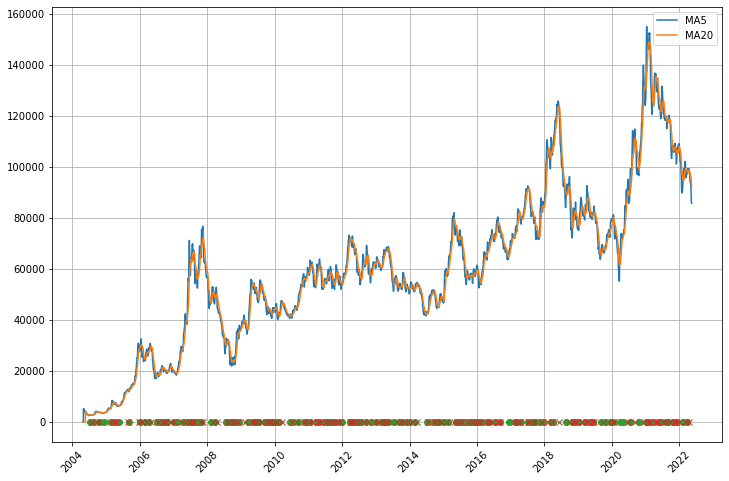

In [40]:
# 이동평균과 골든 / 데드 크로스 시각화
plt.figure(figsize=(12,8)) # 차트 크기 설정
plt.plot(df.index, df['MA5'] , label="MA5")
plt.plot(df.index, df['MA20'] , label="MA20")
plt.plot(df['GC'].iloc[df['GC'].values == True],'o') #골든 크로스 
plt.plot(df['DC'].iloc[df['DC'].values == True],'x') #데드 크로스 
plt.legend(loc='best') #가장 적절한 위치에 설정 
plt.xticks(rotation = 45) #x축 45도 회전 

plt.grid() #격자 
plt.show()

* 데이터 스케일링

In [6]:
# 데이터 스케일링 (preprocessing)

from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
X_data = df.drop(['close'], axis = 1, inplace = False)
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# 타켓 스케일링
y_target = df['close']
scaler1 = MinMaxScaler()
y_target = scaler1.fit_transform(y_target.values.reshape(-1,1))

print(X_data)

[[0.0227409  0.02622569 0.0190656  1.        ]
 [0.0187425  0.0198147  0.01846655 0.2410766 ]
 [0.01884246 0.01824528 0.01698193 0.21006756]
 ...
 [0.51394442 0.50190573 0.52270877 0.07165343]
 [0.50957117 0.51463076 0.52791796 0.05927503]
 [0.52768892 0.51584267 0.5422432  0.03722444]]


* 데이터 분리

In [38]:
# train / validation / test size 설정하기
train_size = int(len(X_data) * 0.9)

# train / test 학습 및 라벨 설정하기
# 종가를 예측하기 위해 종가를 label로 설정
train_x = np.array(X_data[:train_size])
train_y = np.array(y_target[:train_size]).reshape(-1)

test_x = np.array(X_data[train_size:])
test_y = np.array(y_target[train_size:])

print(len(train_x))
print(len(test_x))
print(train_x.shape)
print(train_y.shape)

4023
447
(4023, 4)
(4023,)


In [26]:
from keras.constraints import maxnorm

# build the model
input_dim = train_x.shape[1]

#NOTE: Add default optimizer, otherwise throws error 'optimizer not legal parameter'
def define_model(dropout_rate=0.0):   
    model = Sequential()
    model.add(LSTM(512, input_shape=(1,input_dim)))
    model.add(Dense(1, activation='tanh'))
    model.add(Dropout(dropout_rate))
    
    # compile the model
    model.compile(loss='mse',
                  optimizer='rmsprop',      
                  metrics=['mae', 'mape'])
    return model

# implement the Scikit-Learn classifier interface
# requires model defined as a function, which we already have

model = KerasRegressor(build_fn=define_model, 
                        verbose=1)

dropout_rate = [0.0, 0.2, 0.4]
batch_size = [100, 200, 400]
epochs = [1, 5, 10]

param_grid = dict(dropout_rate=dropout_rate,
                  batch_size=batch_size, 
                  epochs=epochs)

#n_jobs=16 uses 16 CPUs. Try not to do -1 on your system as it may hang!!!
# -1 refers to using all available CPUs
#Cross validation, cv=3
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=16, cv=3)

grid_result = grid.fit(train_x, train_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

C:\Users\gram\AppData\Local\Temp/ipykernel_10820/2903599894.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=define_model,


ValueError: 
All the 81 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gram\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gram\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1147, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 1, 4)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 4), dtype=float32)
      • training=True
      • mask=None


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gram\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gram\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1147, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).
    
    Input 0 of layer "lstm_1" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 1, 4)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 4), dtype=float32)
      • training=True
      • mask=None


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gram\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gram\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1147, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "lstm_2" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 1, 4)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 4), dtype=float32)
      • training=True
      • mask=None


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gram\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gram\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1147, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_3" (type Sequential).
    
    Input 0 of layer "lstm_3" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 1, 4)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 4), dtype=float32)
      • training=True
      • mask=None


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gram\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gram\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1147, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_4" (type Sequential).
    
    Input 0 of layer "lstm_4" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 1, 4)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 4), dtype=float32)
      • training=True
      • mask=None


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gram\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gram\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1147, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\gram\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_5" (type Sequential).
    
    Input 0 of layer "lstm_5" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 1, 4)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 4), dtype=float32)
      • training=True
      • mask=None



In [25]:
time_step = 1
input_dim = train_x.shape[1]

# reshape into (size(개수), time step, 입력 feature)
train_x = train_x.reshape(train_x.shape[0], time_step, input_dim)
test_x = test_x.reshape(test_x.shape[0], time_step, input_dim)

train_x.shape, test_x.shape

((4023, 1, 4), (447, 1, 4))

* 하이퍼 파라미터 설정

In [73]:
 # 학습을 위한 기초 파라메터 설정
learning_rate = 0.01
# 전체 데이터셋에 대한 반복 학습 횟수(500) (Epoch)
training_cnt = 500
# 한번 학습에 사용할 batch size 설정
batch_size =  200
# 입력 피쳐의 개수
input_size = train_x.shape[1]

time_step = 1

* 데이터 변환

In [74]:
# reshape into (size(개수), time step, 입력 feature)
train_x = train_x.reshape(train_x.shape[0], time_step, input_size)
test_x = test_x.reshape(test_x.shape[0], time_step, input_size)

train_x.shape, test_x.shape

((4023, 1, 12), (447, 1, 12))

* RNN 학습
 * Dense는 출력값의 개수
 * Dropout : overfitting을 방지하기 위해 network의 일부를 생략하는 방식<br>
 * optimizer : 훈련 과정을 설정하는 옵티마이저를 설정합니다.
 * loss : 훈련 과정에서 사용할 손실 함수(loss function)를 설정합니다.
 * metrics : 훈련을 모니터링하기 위한 지표를 선택합니다.

In [75]:
model = Sequential()

# hidden_state = output_dim = 512임을 의미
# time_step = 1이므로 1개의 데이터를 이용해서 정답을 만듦
model.add(SimpleRNN(512, input_shape=(time_step, input_size)))

model.add(Dense(1, activation='tanh'))

# Overfitting을 방지하기 위해 Dropout 설정
model.add(Dropout(0.2))

# 오차 및 최적화기 설정하기
# rmsprop : 과거의 모든 기울기를 균일하게 더하지 않고 새로운 기울기의 정보만 반영하도록 해서 학습률이 크게 떨어져 0에 가까워지는 것을 방지
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mape'])
model.summary()

# 학습하기
history = model.fit(train_x, train_y, epochs=training_cnt, \
                    batch_size = batch_size, verbose=1)
val_mse, val_mae, val_mape = model.evaluate(test_x, test_y, verbose=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 512)               268800    
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
 dropout_4 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 269,313
Trainable params: 269,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
21/21 [==============================] - 2s 13ms/step - loss: 0.0347 - mae: 0.1294 - mape: 578.2688
Epoch 2/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0278 - mae: 0.1134 - mape: 12503.3359
Epoch 3/500
21/21 [==============================] - 0s 11ms/step - loss: 0.0296 - mae

21/21 [==============================] - 0s 13ms/step - loss: 0.0256 - mae: 0.0736 - mape: 3156.1943
Epoch 139/500
21/21 [==============================] - 0s 12ms/step - loss: 0.0274 - mae: 0.0771 - mape: 36.2905
Epoch 140/500
21/21 [==============================] - 0s 11ms/step - loss: 0.0264 - mae: 0.0749 - mape: 2557.9387
Epoch 141/500
21/21 [==============================] - 0s 16ms/step - loss: 0.0261 - mae: 0.0743 - mape: 890.1822
Epoch 142/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0262 - mae: 0.0737 - mape: 2899.4741
Epoch 143/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0251 - mae: 0.0718 - mape: 3526.2019
Epoch 144/500
21/21 [==============================] - 0s 15ms/step - loss: 0.0260 - mae: 0.0738 - mape: 3311.9968
Epoch 145/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0267 - mae: 0.0742 - mape: 3175.7515
Epoch 146/500
21/21 [==============================] - 0s 11ms/step - loss: 0.0262 - mae: 0.0743 

21/21 [==============================] - 0s 10ms/step - loss: 0.0271 - mae: 0.0766 - mape: 2950.6843
Epoch 281/500
21/21 [==============================] - 0s 10ms/step - loss: 0.0264 - mae: 0.0739 - mape: 2965.0635
Epoch 282/500
21/21 [==============================] - 0s 12ms/step - loss: 0.0271 - mae: 0.0756 - mape: 2847.1963
Epoch 283/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0256 - mae: 0.0718 - mape: 2823.8206
Epoch 284/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0251 - mae: 0.0722 - mape: 2663.5618
Epoch 285/500
21/21 [==============================] - 0s 9ms/step - loss: 0.0254 - mae: 0.0708 - mape: 2266.4226
Epoch 286/500
21/21 [==============================] - 0s 9ms/step - loss: 0.0245 - mae: 0.0710 - mape: 2859.1833
Epoch 287/500
21/21 [==============================] - 0s 9ms/step - loss: 0.0254 - mae: 0.0721 - mape: 2595.6804
Epoch 288/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0261 - mae: 0.0725 

21/21 [==============================] - 0s 12ms/step - loss: 0.0267 - mae: 0.0740 - mape: 2281.6868
Epoch 423/500
21/21 [==============================] - 0s 10ms/step - loss: 0.0258 - mae: 0.0732 - mape: 3048.5889
Epoch 424/500
21/21 [==============================] - 0s 10ms/step - loss: 0.0247 - mae: 0.0698 - mape: 39.8957
Epoch 425/500
21/21 [==============================] - 0s 12ms/step - loss: 0.0255 - mae: 0.0719 - mape: 2523.3879
Epoch 426/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0257 - mae: 0.0718 - mape: 2956.5808
Epoch 427/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0262 - mae: 0.0739 - mape: 39.4766
Epoch 428/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0239 - mae: 0.0675 - mape: 37.8749
Epoch 429/500
21/21 [==============================] - 0s 15ms/step - loss: 0.0274 - mae: 0.0760 - mape: 2847.4873
Epoch 430/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0246 - mae: 0.0708 - m

* epoch에 따른 손실 변화 확인

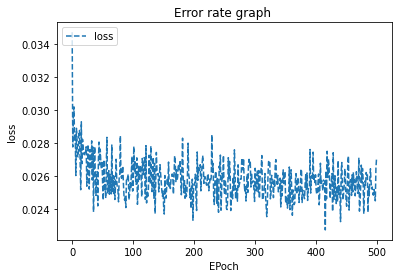

In [76]:
plt.title('Error rate graph ') #plot 제목 설정 
plt.plot(history.history['loss'], linestyle='--') 
plt.legend(['loss'], loc='upper left') #legend 설정
plt.ylabel('loss') #y축 이름 설정 
plt.xlabel('EPoch') #x축 이름 설정 
plt.show()

* 주가 예측

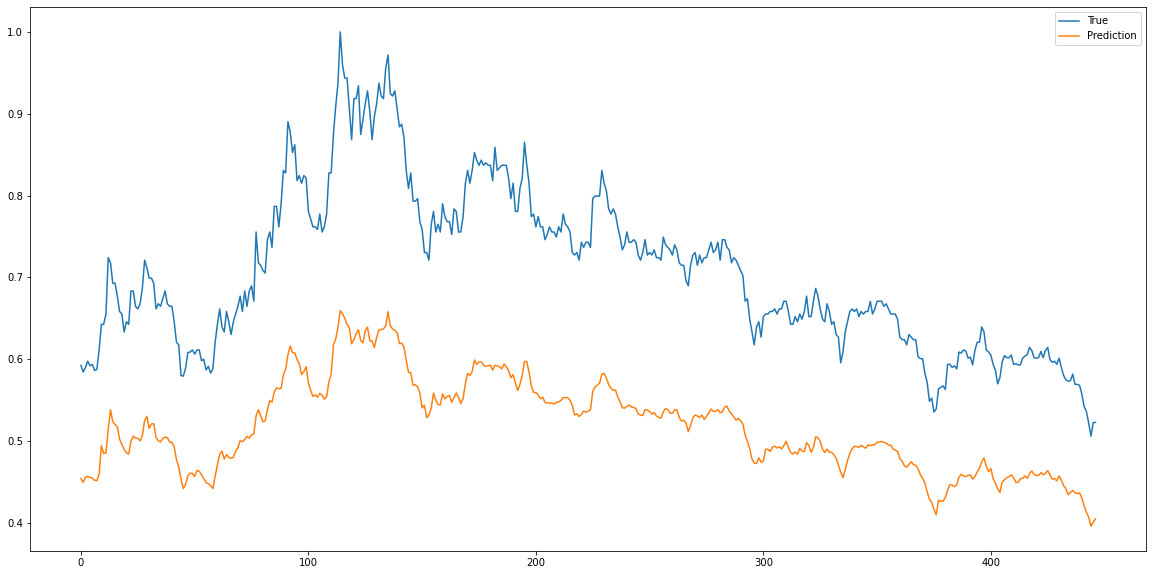

In [77]:
pred = model.predict(test_x)

fig = plt.figure(facecolor='white', figsize=(20, 10)) #차트의 크기/색 설정 
ax = fig.add_subplot(111)
ax.plot(test_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

* 역변환

In [78]:
rescaled_y_test = scaler1.inverse_transform(np.array(test_y).reshape(-1, 1))
rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))

In [79]:
MSE = np.square(np.subtract(rescaled_y_test, rescaled_pred)).mean()
MSE

948216285.4093852